In [1]:
# Time-dependent and spatially-dependent evolutions for the Maxwell-Boltzmann
# distribution function using the BGK (relaxation) collision operator
# Author: Nicholas Proietti

# using necessary packages
using LaTeXStrings, Markdown, DataFrames, Queryverse, Plots, Printf
 
df = load("coronal_loop_data.csv", spacedelim=true, header_exists=true) |> DataFrame


(process:10960): GLib-GIO-WARNING **: 11:46:42.187: Unexpectedly, UWP app `Evernote.Evernote_10.30.6.0_x86__q4d96b2w5wcc2' (AUMId `Evernote.Evernote_q4d96b2w5wcc2!Evernote') supports 1 extensions but has no verbs


,s,ds,n,T
,Float64,Float64,Float64,Float64
1,5.0e6,1.0e7,1.86965e13,20000.0
2,1.5e7,1.0e7,1.67889e13,20000.0
3,2.5e7,1.0e7,1.50764e13,20000.0
4,3.5e7,1.0e7,1.35391e13,20000.0
5,4.5e7,1.0e7,1.21591e13,20000.0
6,5.5e7,1.0e7,1.09201e13,20000.0
7,6.5e7,1.0e7,9.80791e12,20000.0
8,7.5e7,1.0e7,8.80938e12,20000.0
9,8.5e7,1.0e7,7.91291e12,20000.0


In [2]:
println("BGK Equation")
println("Consider a single species with number density-dependent and temperature-dependent collisional frequency")
L"""\left(\dfrac{\partial f_s}{\partial t} \right)_{collisions} \
    = \
    \nu_{ss}(F_s - f_s) \ """

#= Reference: 
Eq. (26)
Bradshaw, S.J., Raymond, J. Collisional and Radiative Processes in Optically Thin Plasmas. Space Sci Rev 178, 271–306 (2013). 
https://doi.org/10.1007/s11214-013-9970-0
=#

BGK Equation
Consider a single species with number density-dependent and temperature-dependent collisional frequency


L"$\left(\dfrac{\partial f_s}{\partial t} \right)_{collisions} \
= \
\nu_{ss}(F_s - f_s) \ $"

In [3]:
m_e = 9.11E-28 # electron mass [g]
k = 1.38E-16 # boltzmann constant [erg*K^-1]
v = range(1e10, -1e10, step=-1e8) # velocity [cm/s]
Λ = 20 # Coulomb logarithm, typically assumed to be 10-20 for solar corona
e = 4.8032045E-10 # electron charge [esu]

T_M = 1e6 # temperature of Maxwellian [K]
T_N = 7e5 # temperature of chosen initial distribution [K]

function Maxwellian(v_Max, T_Max)
    # Maxwellian distribution function for particles moving in only one direction```
    normal = (m_e/(2*pi*k*T_Max))^1.5
    exp_term = exp(-((m_e).*v_Max.*v_Max)/(3*k*T_Max))
    return normal*exp_term
end

Maxwellian (generic function with 1 method)

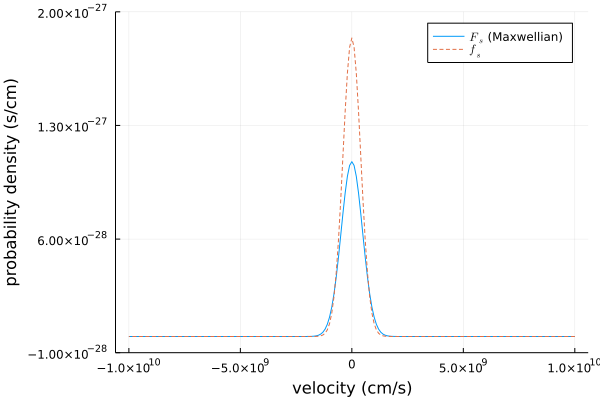

In [4]:
# Initially comparing chosen distribution f_s to Maxwellian F_s for time discretization

plot(v, Maxwellian.(v, T_M), label= L"F_s" * " (Maxwellian)")
plot!(v, Maxwellian.(v, T_N), linestyle = :dash, label= L"f_s")
xlabel!("velocity (cm/s)")
ylabel!("probability density (s/cm)")
ylims!(-1e-28, 2e-27)
#savefig("BGK_initial.png")



┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Downloads\Simple_BGK_Explicit.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114
┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Downloads\Simple_BGK_Implicit.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114
┌ Info: Saved animation to 
│   fn = C:\Users\Acer\Downloads\Simple_BGK_Time_Discretization_Both.gif
└ @ Plots C:\Users\Acer\.julia\packages\Plots\Zuo5g\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Acer\\Downloads\\Simple_BGK_Time_Discretization_Both.gif")
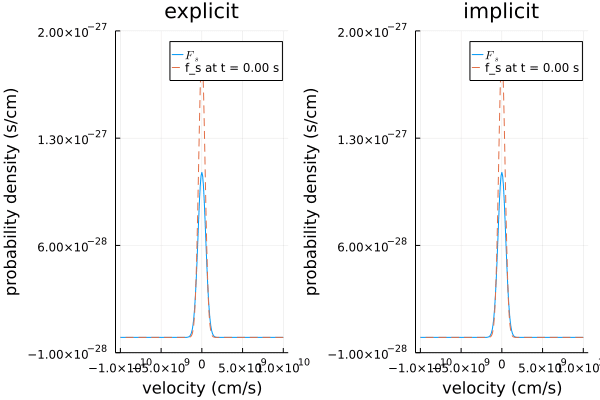

In [5]:
# Time discretization 

nu = 1 # collisional frequency

dt = 10^(-5) # timestep
t = range(0, 3.0, step=dt)

f_s0 = Maxwellian.(v, T_N)
f_s_exp = [f_s0] # explicit method
f_s_imp = [f_s0] # implicit method
F_s = Maxwellian.(v, T_M)

for it in 1:length(t)-1
    push!(f_s_exp, dt*nu*(F_s - f_s_exp[it]) + f_s_exp[it])
    push!(f_s_imp, (f_s_imp[it] + nu*F_s*dt)/(1 + nu*dt))
end

frame_rate = 15 # frames per second for gifs

anim_exp = @animate for i in 1:1000:length(t)
           plot(v, F_s; label=L"F_s")
           plot!(v, f_s_exp[i]; linestyle = :dash, label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           xlabel!("velocity (cm/s)")
           ylabel!("probability density (s/cm)")
           ylims!(-1e-28, 2e-27)
           title!("Simple BGK Model (explicit method)")
       end;

gif(anim_exp, "Simple_BGK_Explicit.gif"; fps=frame_rate)

anim_imp = @animate for i in 1:1000:length(t)
           plot(v, F_s; label=L"F_s")
           plot!(v, f_s_imp[i]; linestyle = :dash, label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           xlabel!("velocity (cm/s)")
           ylabel!("probability density (s/cm)")
           ylims!(-1e-28, 2e-27)
           title!("Simple BGK Model (implicit method)")
       end;

gif(anim_imp, "Simple_BGK_Implicit.gif"; fps=frame_rate)

anim_both = @animate for i in 1:1000:length(t)
           a = plot(v, F_s; label=L"F_s")
           a = plot!(v, f_s_exp[i]; linestyle = :dash, label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           a = title!("explicit")
           b = plot(v, F_s; label=L"F_s")
           b = plot!(v, f_s_imp[i]; linestyle = :dash, label=@sprintf("f_s at t = %.2f s", t[i]), ylims=(0.0,1.5))
           b = title!("implicit")
           plot(a, b, layout = (1, 2), legend = true)
           xlabel!("velocity (cm/s)")
           ylabel!("probability density (s/cm)")
           ylims!(-1e-28, 2e-27)
            
       end;

gif(anim_both, "Simple_BGK_Time_Discretization_Both.gif"; fps=frame_rate)

In [ ]:
# Spatial discretization  (explicit method)

nu_exp = 1 # collisional frequency [s^-1]
v_pos = range(0, 1e10, step=1e8) # positive velocity [cm/s]
v_neg = range(0, -1e10, step=-1e8) # negative velocity [cm/s]

f_s_pos_exp = [Maxwellian.(v_pos, df.T[1])] # because boundary density is high at left footpoint, assume f_N = f_M
f_s_neg_exp = [Maxwellian.(v_neg, df.T[end])] # because boundary density is high at right footpoint, assume f_N = f_M

for is in 1:length(df.s) # for positive velocities, integrate from 0 to s_max
    local_f_s_pos_exp = Maxwellian.(v_pos, df.T[is])
    push!(f_s_pos_exp, @. f_s_pos_exp[is] - (nu_exp/v_pos)*(f_s_pos_exp[is] - local_f_s_pos_exp)*(df.ds[is]))
end

for is in reverse(eachindex(df.s)) # for negative velocities, integrate from s_max to 0 
    local_f_s_neg_exp = Maxwellian.(v_neg, df.T[is])
    push!(f_s_neg_exp, f_s_neg_exp[length(df.s)+1-is] + (nu_exp./v_neg).*(f_s_neg_exp[length(df.s)+1-is] - local_f_s_neg_exp)*(df.ds[is]))
end

anim = @animate for i in 1:length(df.s)
           plot([v_neg; v_pos], [f_s_neg_exp[i]; f_s_pos_exp[i]]; label=@sprintf("f_s at s = %.3e cm", df.s[i]))
           xlabel!("velocity (cm/s)")
           ylabel!("probability density (s/cm)")
           title!("Spatially-Dependent Maxwellian (explicit)")
           ylims!(-1e-28, 2e-27)
       end;

gif(anim, "Simple_BGK_Spatial_Discretization_Exp_ConstNu.gif"; fps=30)

In [ ]:
# Spatial discretization  (implicit method)

nu_imp = 1 # collisional frequency [s^-1]
v_pos = range(0, 1e10, step=1e8) # positive velocity [cm/s]
v_neg = range(0, -1e10, step=-1e8) # negative velocity [cm/s]

scale_factor = 1

f_s_pos_imp = [Maxwellian.(v_pos, df.T[1])] # because boundary density is high at left footpoint, assume f_N = f_M
f_s_neg_imp = [Maxwellian.(v_neg, df.T[end])] # because boundary density is high at right footpoint, assume f_N = f_M

for is in 1:length(df.s) # for positive velocities, integrate from 0 to s_max
    local_f_s_pos = Maxwellian.(v_pos, df.T[is])  
    push!(f_s_pos_imp, @. (f_s_pos_imp[is] + (nu_imp/v_pos)*local_f_s_pos*df.ds[is])/(1 + (nu_imp/v_pos)*(df.ds[is])))
    
end

for is in reverse(eachindex(df.s)) # for negative velocities, integrate from s_max to 0 
    local_f_s_neg = Maxwellian.(v_neg, df.T[is])
    push!(f_s_neg_imp, (f_s_neg_imp[length(df.s)+1-is] .- (nu_imp./v_neg).*local_f_s_neg.*df.ds[is])./(1 .- (nu_imp./v_neg).*(df.ds[is])))
end

anim = @animate for i in 1:length(df.s)
           plot([v_neg; v_pos], [f_s_neg_imp[i]; f_s_pos_imp[i]]; label=@sprintf("f_s at s = %.3e cm", df.s[i]))
           xlabel!("velocity (cm/s)")
           ylabel!("probability density (s/cm)")
           title!("Spatially-Dependent Maxwellian (implicit)")
           ylims!(-1e-28, 2e-27)
       end;

gif(anim, "Simple_BGK_Spatial_Discretization_Imp_ConstNu.gif"; fps=30)
